# Vector Quantized Auto-Encoder

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import data_loader

batch_size = 128
lr = .001

dim_input = (3, 32, 32)
dim_hidden = 400
dim_latent = 200
beta_commitment = 0.25

train_loader, validation_loader, test_loader = data_loader.load_cifar10(batch_size=batch_size)

torch.cuda.is_available()

Files already downloaded and verified


True

torch.Size([3, 32, 32])


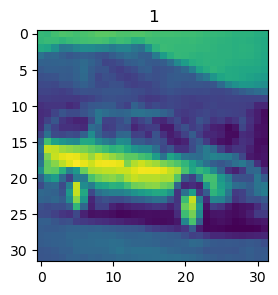

In [17]:
import matplotlib.pyplot as plt

print(train_loader.dataset[4][0].shape)

plt.figure(figsize=(3, 3))
plt.title(f"{train_loader.dataset[4][1]}")
plt.imshow(train_loader.dataset[4][0][0])
plt.show()

In [ ]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super(VectorQuantizer, self).__init__()
    
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    # initialize weights of imbedding from uniform distribution
    self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)
    self.commitment_cost = commitment_cost
    
  def forward(self, inputs):
    inputs = inputs.permute(0,2,3,1).contiguous()
    input_shape = inputs.shape
    
    flat_input = inputs.view(-1, self.embedding_dim)
    
    # distance between choice of embeddings and input
    distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                 + torch.sum(self.embedding.weight**2, dim=1)
                 - 2 *torch.matmul(flat_input, self.embedding.weight.t()))
    
    # encoding to index of closest embeddings to input
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings)
    encodings.scatter(1, encoding_indices, 1)
    
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
    
    e_latent_loss = functional.mse_loss(quantized.detach(), inputs)
    q_latent_loss = functional.mse_loss(quantized, inputs.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss
    
    quantized = inputs + (quantized - inputs).detach()
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
    
    return loss, quantized.permute(0, 3, 1, 2).continguous(), perplexity, encodings